# Handling Excel Files in Python

**Author:** Luis Paulo Vinatea Barberena  
**Date:** 2025-05-21  

## Overview

When you need to work with Excel files in Python, you can use the `openpyxl` library. This library allows you to read and write Excel files in the `.xlsx` format.
It is a powerful tool for data manipulation and analysis, especially when dealing with large datasets.

## 1. Setup and Environment

In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import openpyxl
from IPython.display import display, HTML

# Import project utilities
import sys
sys.path.append('../')
from src.utils.data_processing import *  # noqa: F403
from src.utils.visualization import *  # noqa: F403

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', None)

# For reproducibility
np.random.seed(42)

## 2. Data Loading and Inspection

In [2]:
def set_path():
    global XLSX_DATA_PATH
    XLSX_DATA_PATH = "../data/raw/*.xlsx"


# Set the path for the data files
set_path()


def load_data():
    df_count = 1
    try:
        for file in glob.glob(XLSX_DATA_PATH):
            print(f"Loading data from {file}")

            # Use openpyxl to get detailed workbook information
            wb = openpyxl.load_workbook(file, data_only=True, read_only=True)
            file_basename = os.path.basename(file)

            print(f"\nWorkbook: {file_basename}")
            print(
                f"Contains {len(wb.sheetnames)} sheets: {', '.join(wb.sheetnames)}"
            )

            for sheet_name in wb.sheetnames:
                sheet = wb[sheet_name]
                print(f"\n  Sheet: '{sheet_name}'")

                # Get sheet dimensions
                if not sheet.max_row or not sheet.max_column:
                    print(
                        f"  Warning: Sheet '{sheet_name}' appears to be empty or corrupted"
                    )
                    continue

                print(
                    f"  Dimensions: {sheet.max_row} rows x {sheet.max_column} columns"
                )

                # Check for merged cells - handle ReadOnlyWorksheet gracefully
                try:
                    merged_cells = list(sheet.merged_cells.ranges)
                    if merged_cells:
                        print(
                            f"  Contains {len(merged_cells)} merged cell ranges"
                        )
                except AttributeError:
                    print(
                        "  Note: Cannot check merged cells in read-only mode"
                    )

                # Create dataframe with numerical suffix
                df_name = f"df{df_count}"

                # Use pandas to read the Excel sheet with appropriate options
                globals()[df_name] = pd.read_excel(
                    file,
                    sheet_name=sheet_name,
                    header=None,  # Start without assuming headers
                    na_values=["NA", "N/A", ""],
                    keep_default_na=True,
                )

                # Try to detect if there are real headers in the sheet
                potential_header_row = None
                df = globals()[df_name]

                # Look at first 10 rows to find potential header
                for i in range(min(10, len(df))):
                    # Check if this row has string values that could be headers
                    str_count = sum(
                        1 for x in df.iloc[i] if isinstance(x, str)
                    )
                    if (
                        str_count > 0.5 * df.shape[1]
                    ):  # More than half are strings
                        potential_header_row = i
                        break

                # If we found a likely header row, reload with this row as header
                if potential_header_row is not None:
                    globals()[df_name] = pd.read_excel(
                        file,
                        sheet_name=sheet_name,
                        header=potential_header_row,
                        na_values=["NA", "N/A", ""],
                        keep_default_na=True,
                    )
                    print(
                        f"  Detected header at row {potential_header_row + 1}"
                    )

                print(
                    f"  Loaded {df_name} with shape {globals()[df_name].shape}"
                )
                df_count += 1

            # Close the workbook to free resources
            wb.close()

        print(f"\nSuccessfully loaded {df_count - 1} dataframes.")

    except Exception as e:
        print(f"Error loading data: {e}")
        raise


# Load the data
load_data()

Loading data from ../data/raw/kpis_ambientales_2025.xlsx

Workbook: kpis_ambientales_2025.xlsx
Contains 4 sheets: DATOS, Huella 2025, Calculo de reduccion, INDICADORES

  Sheet: 'DATOS'
  Dimensions: 57 rows x 8 columns
  Note: Cannot check merged cells in read-only mode
  Detected header at row 4
  Loaded df1 with shape (53, 8)

  Sheet: 'Huella 2025'
  Dimensions: 21 rows x 19 columns
  Note: Cannot check merged cells in read-only mode
  Detected header at row 6
  Loaded df2 with shape (15, 19)

  Sheet: 'Calculo de reduccion'
  Dimensions: 9 rows x 8 columns
  Note: Cannot check merged cells in read-only mode
  Detected header at row 3
  Loaded df3 with shape (6, 8)

  Sheet: 'INDICADORES'
  Dimensions: 14 rows x 9 columns
  Note: Cannot check merged cells in read-only mode
  Detected header at row 5
  Loaded df4 with shape (9, 9)
Loading data from ../data/raw/objetivos_y_estrategias_2025.xlsx

Workbook: objetivos_y_estrategias_2025.xlsx
Contains 1 sheets: Hoja1

  Sheet: 'Hoja1'
  

In [3]:
# Get all dataframe variables (those starting with 'df')
dfs = {
    name: obj
    for name, obj in globals().items()
    if isinstance(obj, pd.DataFrame) and name.startswith("df")
}

print(f"Found {len(dfs)} dataframes in the environment\n")


def print_dataframe_info(dfs):
    for df_name, df_obj in dfs.items():
        print(f"{'=' * 50}")
        print(f"DataFrame: {df_name} with shape {df_obj.shape}")
        print(f"{'=' * 50}")

        # Basic info
        print("\n📊 Basic Information:")
        print(f"  - Rows: {df_obj.shape[0]}")
        print(f"  - Columns: {df_obj.shape[1]}")
        print(
            f"  - Missing values: {df_obj.isna().sum().sum()} ({df_obj.isna().sum().sum() / (df_obj.shape[0] * df_obj.shape[1]):.1%} of all cells)"
        )

        # Data types
        print("\n📋 Data Types:")
        for dtype, count in df_obj.dtypes.value_counts().items():
            print(f"  - {dtype}: {count} columns")

        # Column analysis for unnamed columns
        unnamed_cols = [col for col in df_obj.columns if "Unnamed" in str(col)]
        if unnamed_cols:
            print(f"\n⚠️ Found {len(unnamed_cols)} unnamed columns")

        # Check for potential KPI indicators
        if "Unnamed: 1" in df_obj.columns and "Unnamed: 2" in df_obj.columns:
            unique_sites = df_obj["Unnamed: 1"].dropna().unique()
            unique_indicators = df_obj["Unnamed: 2"].dropna().unique()

            print("\n📈 Content Analysis:")
            print(f"  - Potential sites: {len(unique_sites)}")
            print(f"  - Potential indicators: {len(unique_indicators)}")

            # Display some examples
            if isinstance(unique_sites, str):
                if len(unique_sites) > 0:
                    print("\n🏢 Sample sites:", ", ".join(unique_sites[:5]))
                if len(unique_indicators) > 0:
                    print(
                        "\n📏 Sample indicators:",
                        ", ".join(unique_indicators[:5]),
                    )

        # Preview with better formatting
        print("\n🔍 Data Preview:")
        print(df_obj.head(3))
        print("\n\n")

    # Call the function to print dataframe info


print_dataframe_info(dfs)


Found 5 dataframes in the environment

DataFrame: df1 with shape (53, 8)

📊 Basic Information:
  - Rows: 53
  - Columns: 8
  - Missing values: 205 (48.3% of all cells)

📋 Data Types:
  - object: 7 columns
  - float64: 1 columns

⚠️ Found 2 unnamed columns

🔍 Data Preview:
   Unnamed: 0     STIOS INDICADOR Unnamed: 3 January February  March  April
0         NaN      TSAN      Kw/h        NaN   54850    59992  48422  58710
1         NaN       GLP       NaN        NaN   38136    41690  33650  40797
2         NaN  AVIACION       NaN        NaN   15178     6500   8244   6612



DataFrame: df2 with shape (15, 19)

📊 Basic Information:
  - Rows: 15
  - Columns: 19
  - Missing values: 169 (59.3% of all cells)

📋 Data Types:
  - float64: 17 columns
  - object: 2 columns

⚠️ Found 7 unnamed columns

📈 Content Analysis:
  - Potential sites: 3
  - Potential indicators: 14

🔍 Data Preview:
   Unnamed: 0  Unnamed: 1                                       Unnamed: 2  \
0         NaN         1.0  Combu

In [4]:
# Function to clean and standardize column headers
def standardize_headers(dfs):
    print(f"{'=' * 50}")
    print("STANDARDIZING DATAFRAME HEADERS")
    print(f"{'=' * 50}\n")
    
    for df_name, df_obj in dfs.items():
        print(f"Processing {df_name}...")
        
        # Check if we have unnamed columns that might be headers
        unnamed_cols = [col for col in df_obj.columns if "Unnamed" in str(col)]
        
        if len(unnamed_cols) > 0:
            print(f"  Found {len(unnamed_cols)} unnamed columns")
            
            # Try to find descriptive column headers from the data
            # This is similar to how load_data() detects header rows
            original_cols = df_obj.columns.tolist()
            
            # Look at first few rows for potential header material
            for i in range(min(5, len(df_obj))):
                row = df_obj.iloc[i]
                
                # Check if this row has mostly non-null string values
                str_values = [v for v in row if isinstance(v, str) and pd.notna(v)]
                
                if len(str_values) >= len(unnamed_cols) * 0.7:  # If at least 70% of unnamed cols have string values
                    # Create a mapping from original columns to new names
                    new_names = {}
                    
                    for j, col in enumerate(original_cols):
                        if "Unnamed" in str(col) and j < len(row) and pd.notna(row.iloc[j]) and isinstance(row.iloc[j], str):
                            new_names[col] = str(row.iloc[j]).strip()
                    
                    if new_names:
                        print(f"  Found potential header values in row {i+1}")
                        print(f"  Renaming {len(new_names)} columns")
                        
                        # Create a copy to avoid modifying during iteration
                        df_copy = df_obj.copy()
                        
                        # Rename the columns
                        df_copy = df_copy.rename(columns=new_names)
                        
                        # Drop the row that was used as header
                        df_copy = df_copy.drop(index=i)
                        
                        # Update the dataframe in the dictionary
                        dfs[df_name] = df_copy
                        
                        print(f"  New columns: {list(new_names.values())}")
                        break
        
        # Fix date-related column names for consistency
        date_mappings = {
            'January': 'Enero', 'February': 'Febrero', 'March': 'Marzo', 'April': 'Abril',
            'May': 'Mayo', 'June': 'Junio', 'July': 'Julio', 'August': 'Agosto',
            'September': 'Septiembre', 'October': 'Octubre', 'November': 'Noviembre', 'December': 'Diciembre'
        }
        
        # Check if we have any date columns to standardize
        date_cols = [col for col in dfs[df_name].columns if str(col) in date_mappings]
        
        if date_cols:
            print(f"  Standardizing {len(date_cols)} date-related columns to Spanish format")
            dfs[df_name] = dfs[df_name].rename(columns=date_mappings)
    
    print("\nHeader standardization complete!")
    return dfs

# Apply header standardization
dfs = standardize_headers(dfs)

# Call the function to print dataframe info to see the changes
print_dataframe_info(dfs)

STANDARDIZING DATAFRAME HEADERS

Processing df1...
  Found 2 unnamed columns
  Standardizing 4 date-related columns to Spanish format
Processing df2...
  Found 7 unnamed columns
Processing df3...
  Found 1 unnamed columns
Processing df4...
  Found 2 unnamed columns
  Found potential header values in row 1
  Renaming 1 columns
  New columns: ['variación porcentual mensual del consumo']
Processing df5...

Header standardization complete!
DataFrame: df1 with shape (53, 8)

📊 Basic Information:
  - Rows: 53
  - Columns: 8
  - Missing values: 205 (48.3% of all cells)

📋 Data Types:
  - object: 7 columns
  - float64: 1 columns

⚠️ Found 2 unnamed columns

🔍 Data Preview:
   Unnamed: 0     STIOS INDICADOR Unnamed: 3  Enero Febrero  Marzo  Abril
0         NaN      TSAN      Kw/h        NaN  54850   59992  48422  58710
1         NaN       GLP       NaN        NaN  38136   41690  33650  40797
2         NaN  AVIACION       NaN        NaN  15178    6500   8244   6612



DataFrame: df2 with shape (

In [5]:
# Remove all empty rows and columns from all dataframes
def remove_empty_rows_and_cols(dfs):
    for df_name, df_obj in dfs.items():
        dfs[df_name] = df_obj.dropna(how="all").dropna(axis=1, how="all")
        print(
            f"Removed empty rows and columns from {df_name}, new shape: {dfs[df_name].shape}"
        )


# Call the function to remove empty rows and columns
remove_empty_rows_and_cols(dfs)

# Call the function to print dataframe info
print_dataframe_info(dfs)

Removed empty rows and columns from df1, new shape: (43, 7)
Removed empty rows and columns from df2, new shape: (14, 10)
Removed empty rows and columns from df3, new shape: (6, 7)
Removed empty rows and columns from df4, new shape: (5, 8)
Removed empty rows and columns from df5, new shape: (33, 11)
DataFrame: df1 with shape (43, 7)

📊 Basic Information:
  - Rows: 43
  - Columns: 7
  - Missing values: 82 (27.2% of all cells)

📋 Data Types:
  - object: 7 columns

⚠️ Found 1 unnamed columns

🔍 Data Preview:
      STIOS INDICADOR Unnamed: 3  Enero Febrero  Marzo  Abril
0      TSAN      Kw/h        NaN  54850   59992  48422  58710
1       GLP       NaN        NaN  38136   41690  33650  40797
2  AVIACION       NaN        NaN  15178    6500   8244   6612



DataFrame: df2 with shape (14, 10)

📊 Basic Information:
  - Rows: 14
  - Columns: 10
  - Missing values: 24 (17.1% of all cells)

📋 Data Types:
  - float64: 8 columns
  - object: 2 columns

⚠️ Found 6 unnamed columns

📈 Content Analysis:


In [6]:
# Analyze and selectively handle NaN values in dataframes
def handle_nan_values(dfs):
    for df_name, df_obj in dfs.items():
        # Count NaNs before any operation
        total_cells = df_obj.shape[0] * df_obj.shape[1]
        nan_count_before = df_obj.isna().sum().sum()
        nan_percentage = (
            nan_count_before / total_cells if total_cells > 0 else 0
        )

        print(f"\n{'-' * 50}")
        print(f"NaN analysis for {df_name}:")
        print(
            f"- Total NaN values: {nan_count_before} ({nan_percentage:.1%} of all cells)"
        )

        # Identify columns with high NaN percentages
        column_nan_pct = df_obj.isna().mean().sort_values(ascending=False)
        high_nan_cols = column_nan_pct[column_nan_pct > 0.8].index.tolist()

        if high_nan_cols:
            print(f"- Columns with >80% NaNs: {', '.join(high_nan_cols)}")
            # Option to drop columns with too many NaNs
            df_obj = df_obj.drop(columns=high_nan_cols)

        # Instead of dropping all NaN rows, only drop rows where critical columns are NaN
        # For this example, we'll consider the first non-unnamed column as critical
        critical_cols = [
            col for col in df_obj.columns if "Unnamed" not in str(col)
        ]

        if critical_cols:
            print(f"- Critical columns identified: {', '.join(critical_cols)}")
        else:
            # If all columns are unnamed, use columns 1 and 2 as they often contain key information
            critical_cols = (
                [df_obj.columns[1], df_obj.columns[2]]
                if len(df_obj.columns) > 2
                else []
            )
            print(
                f"- Using unnamed columns as critical: {', '.join(map(str, critical_cols))}"
            )

        # Only count rows where all critical columns are NaN
        if critical_cols:
            rows_to_drop = df_obj[
                df_obj[critical_cols].isna().all(axis=1)
            ].index
            print(
                f"- Found {len(rows_to_drop)} rows where all critical columns are NaN"
            )

            # Uncomment to actually drop these rows
            df_obj = df_obj.drop(index=rows_to_drop)

        # Update the dataframe in the dictionary
        dfs[df_name] = df_obj

        print(f"- Final shape after analysis: {df_obj.shape}")

    return dfs


# Call the function to analyze NaN values
dfs = handle_nan_values(dfs)

# Call the function to print dataframe info
print_dataframe_info(dfs)


--------------------------------------------------
NaN analysis for df1:
- Total NaN values: 82 (27.2% of all cells)
- Columns with >80% NaNs: Unnamed: 3
- Critical columns identified: STIOS, INDICADOR, Enero, Febrero, Marzo, Abril
- Found 0 rows where all critical columns are NaN
- Final shape after analysis: (43, 6)

--------------------------------------------------
NaN analysis for df2:
- Total NaN values: 24 (17.1% of all cells)
- Columns with >80% NaNs: Unnamed: 18
- Critical columns identified: Enero, Febrero, marzo, abril
- Found 2 rows where all critical columns are NaN
- Final shape after analysis: (12, 9)

--------------------------------------------------
NaN analysis for df3:
- Total NaN values: 1 (2.4% of all cells)
- Critical columns identified: Material reciclado, Enero, Febrero, marzo, Abril, Emisiones evitadas (aproximado), TOTAL
- Found 0 rows where all critical columns are NaN
- Final shape after analysis: (6, 7)

--------------------------------------------------


In [7]:
# Preview the cleaned dataframes in a html table, set scrollable
def preview_dataframes(dfs):
    for df_name, df_obj in dfs.items():
        print(f"{'=' * 50}")
        print(f"Previewing {df_name}...")

        # Create HTML table and add CSS for scrollability
        html_table = df_obj.head(10).to_html(index=False, max_rows=10)

        # Wrap table in a div with scroll styling
        styled_html = f"""
        <div style="overflow-x: auto; max-height: 500px; overflow-y: auto;">
            {html_table}
        </div>
        """

        display(HTML(styled_html))
        print(f"{'=' * 50}\n")


# Call the function to preview dataframes
preview_dataframes(dfs)

Previewing df1...


STIOS,INDICADOR,Enero,Febrero,Marzo,Abril
TSAN,Kw/h,54850,59992,48422,58710
GLP,NaN,38136,41690,33650,40797
AVIACION,NaN,15178,6500,8244,6612
ULTRAPAR,NaN,11826,12064,10368,10376
Retail COCO/CODO,NaN,6819,6423,6671,7300
FLUVIAL,NaN,NaN,NaN,NaN,NaN
TOTAL,NaN,126809,126669,107355,123795
TOTAL PY,484628,NaN,NaN,NaN,NaN
STIOS,INDICADOR,January,February,March,April
TSAN,Residuos SOLIDOS Peligrosos Solidos,193360,1180,NaN,630



Previewing df2...


Unnamed: 1,Unnamed: 2,Unnamed: 3,Enero,Febrero,marzo,abril,Unnamed: 16,Unnamed: 17
1.0,Combustibles - Diesel (Remolcadores y Barcazas),Consumo de Diesel en litros,617447.0,512860.0,635003.0,560917.0,2.670,6211.026090
1.0,Combustibles - Diesel Flota puma,Consumo de Diesel en litros,3094.0,2942.0,4216.0,3747.0,2.670,37.377330
1.0,Combustible - Nafta vehiculos Flota Puma,Consumo de Nafta en Litros,605.4,516.6,624.0,632.0,2.300,5.469400
3.0,Consumo de Agua terminales,Consumo de Agua en Litros,474.0,371.0,406.0,223.0,0.395,0.582230
2.0,Electricidad (Terminales),Consumo eléctrico en kWh,126789.0,126668.0,107355.0,213795.0,0.004,2.298428
3.0,Residuos Solidos Peligrosos terminales,Cantidad de residuos en kg,193360.0,1920.0,0.0,630.0,0.450,88.159500
3.0,Residuos Liquidos Peligroso terminales,Cantidad de efluentes en Litros,25190.0,62080.0,54720.0,28120.0,0.500,85.055000
3.0,Residuos Comunes terminales,Cantidad de residuos en kg,6079.0,2233.0,2701.0,4510.0,0.400,6.209200
3.0,Flota de camiones y flota de vehiculos pool,Distancia recorrida en km,208932.0,225506.0,208975.0,299678.0,0.180,169.756380
3.0,Residuos Peligrosos Fluvial,Cantidad de efluentes en Litros,4550.0,6250.0,3650.0,5750.0,0.500,10.100000



Previewing df3...


Material reciclado,Enero,Febrero,marzo,Abril,Emisiones evitadas (aproximado),TOTAL
Papel/cartón,60,32,27,29,"~1,5 kg CO₂e por kg reciclado",222.0
Plástico,8,8,10,5,"~1,8 kg CO₂e por kg reciclado",55.8
Aluminio,0,0,0,0,"~9,2 kg CO₂e por kg reciclado",0.0
Vidrio,0,0,0,0,"~0,3 kg CO₂e por kg reciclado",0.0
Polietileno,1,0,0,0,"~1,8 kg CO₂e por kg reciclado",1.8
TOTAL,69,40,37,34,NaN,279.6



Previewing df4...


Indicador,variación porcentual mensual del consumo,Frecuencia,Formula,Enero,Febrero,Marzo,Aril
Consumo de combustible Diesel (litros),variación porcentual mensual del consumo,mensual,((Consumo mes anterior - Consumo mes actual) / Consumo mes anterior) * 101,-78.270093,20.305660,-19.367385,0.117289
Reducción mensual de Emisiones de CO2,Emisiones generadas,Mensual,((Emisiones del mes anterior - Emisiones mes actual) / Emisiones mes anterior) * 100,NaN,19.152501,-22.025498,0.108906
Generación de residuos Reciclados,% de Residuos reciclados,Mensual,(Total de residuos reciclados / total de residuos generados) * 100,1.151151,1.791312,1.369863,0.646326
"*Si el resultado es positivo, significa que hugo una reducción en lo consumido/producido",NaN,NaN,NaN,NaN,NaN,NaN,NaN
"*Si el resultado es negativo, indica que el consumo aumentó respecto al mes anterior.",NaN,NaN,NaN,NaN,NaN,NaN,NaN



Previewing df5...


Iten,Origen,Objetivo,Meta,Criterios Evaluación,Responsable,"Estrategía ""que""",Acciones Realizadas
NaN,NaN,NaN,NaN,Desempeño,NaN,NaN,NaN
1.0,Master Plan,Reciclar toda la basura posible generada en nuestros Terminales y Barcos (Fluvial),Lograr reciclar mínimo 391Kg de basura en las Terminales y Fluvial conforme meta,Logra: Reciclar minimo 391kg de basura,Lorena,* Mejor segregación de residuos\n*Mejor control en cantidad de residuos reciclable generados\n* Eco puntos de Reciclaje\n*Campañas de reciclajes.,Inspecciones y control para una correcta segregación de residuos con Audorias realizas.
NaN,NaN,NaN,NaN,Supera: Reciclar entre 392kg a 500kg de basura,NaN,NaN,Procedimiento para la estandarización de residuos
NaN,NaN,NaN,NaN,Excede: Reciclar mas 500kg de basura en Impala Paraguay,NaN,NaN,Proyecto de convenio con la empresa soluciones Ecologicas.
NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hasta abril logramos reciclar 180 Kg
2.0,Master Plan,Concientizar empleados y proveedores de servicio de Impala con relación a generación de basuras en nuestros sitios,Desarrollar una Campaña Ambiental con enfoque en concientización Ambiental y reducción en la generación de basuras,Logra: Desarrollar la Campaña de manera estructurada a través de un plan de ejecución,Lorena,"*Lanzar la campaña en Junio de ""Menos basura, más futuro""",No se logró aun la nueva clasificación aun de residuos sin embargo esta en proceso de presentación a gerencia el desafío de plásticos para que vaya de la mano lo capacitación a los colaboradores con las acciones a desarrollar.
NaN,NaN,NaN,NaN,Supera: Desarrollar la Campaña de manera estructurada a través de un plan de ejecucion y que el plan sea implementado uno 95%,NaN,NaN,NaN
NaN,NaN,NaN,NaN,Excede: Desarrollar la Campaña de manera estructurada a traves de un plan de ejecucion y que el plan sea implementado uno 100%,NaN,NaN,NaN
3.0,Master Plan,Reducción de la huella de carbono,Definir proyecto para reducción de 5% la huella de carbono,Logra: Desarrollo del Proyeco + reducion de 5% la huella de carbono,Lorena,* Proyecto de eficiencia energetica \n* Campaña de Reciclaje \n* Campaña de Reforestación \n* Proyecto disminución de consumo de combustible,Proyecto de 100% iluminación en barcos e inyección de biocombustible. El proyecto de iluminación Leed ya fue compartido a Juan Rolon supervisor de Mantenimiento.
NaN,NaN,NaN,NaN,Supera: Desarrollo del Proyeco + reducion de 6% a 10% la huella de carbono,NaN,NaN,Una vez actualizado la nueva clasificación de residuos lanzar en septiembre una fuerte campaña de reciclaje.


In [8]:
# Get datatypes of all columns in all dataframes and print in a prettified dictionary
# Print in separate tables for each dataframe
def get_dtypes(dfs):
    for df_name, df_obj in dfs.items():
        print(f"{'=' * 50}")
        print(f"DataFrame: {df_name} with shape {df_obj.shape}")
        print(f"{'=' * 50}")

        # Get dtypes
        dtypes = df_obj.dtypes

        # Create a DataFrame for better visualization
        dtype_df = pd.DataFrame(dtypes).reset_index()
        dtype_df.columns = ["Column", "Data Type"]

        # Display the DataFrame
        display(HTML(dtype_df.to_html(index=False)))
        print(f"{'=' * 50}\n")


# Call the function to get dtypes
get_dtypes(dfs)


DataFrame: df1 with shape (43, 6)


Column,Data Type
STIOS,object
INDICADOR,object
Enero,object
Febrero,object
Marzo,object
Abril,object



DataFrame: df2 with shape (12, 9)


Column,Data Type
Unnamed: 1,float64
Unnamed: 2,object
Unnamed: 3,object
Enero,float64
Febrero,float64
marzo,float64
abril,float64
Unnamed: 16,float64
Unnamed: 17,float64



DataFrame: df3 with shape (6, 7)


Column,Data Type
Material reciclado,object
Enero,int64
Febrero,int64
marzo,int64
Abril,int64
Emisiones evitadas (aproximado),object
TOTAL,float64



DataFrame: df4 with shape (5, 8)


Column,Data Type
Indicador,object
variación porcentual mensual del consumo,object
Frecuencia,object
Formula,object
Enero,float64
Febrero,float64
Marzo,float64
Aril,float64



DataFrame: df5 with shape (33, 8)


Column,Data Type
Iten,float64
Origen,object
Objetivo,object
Meta,object
Criterios Evaluación,object
Responsable,object
"Estrategía ""que""",object
Acciones Realizadas,object


In [9]:
# TitleCase all column names
def title_case_columns(dfs):
    for df_name, df_obj in dfs.items():
        print(f"{'=' * 50}")
        print(f"DataFrame: {df_name} with shape {df_obj.shape}")
        print(f"{'=' * 50}")

        # TitleCase the columns
        df_obj.columns = df_obj.columns.str.title()

        # Display the modified DataFrame
        display(HTML(df_obj.head(10).to_html(index=False)))
        print(f"{'=' * 50}\n")


# Call the function to title case columns
title_case_columns(dfs)

DataFrame: df1 with shape (43, 6)


Stios,Indicador,Enero,Febrero,Marzo,Abril
TSAN,Kw/h,54850,59992,48422,58710
GLP,NaN,38136,41690,33650,40797
AVIACION,NaN,15178,6500,8244,6612
ULTRAPAR,NaN,11826,12064,10368,10376
Retail COCO/CODO,NaN,6819,6423,6671,7300
FLUVIAL,NaN,NaN,NaN,NaN,NaN
TOTAL,NaN,126809,126669,107355,123795
TOTAL PY,484628,NaN,NaN,NaN,NaN
STIOS,INDICADOR,January,February,March,April
TSAN,Residuos SOLIDOS Peligrosos Solidos,193360,1180,NaN,630



DataFrame: df2 with shape (12, 9)


Unnamed: 1,Unnamed: 2,Unnamed: 3,Enero,Febrero,Marzo,Abril,Unnamed: 16,Unnamed: 17
1.0,Combustibles - Diesel (Remolcadores y Barcazas),Consumo de Diesel en litros,617447.0,512860.0,635003.0,560917.0,2.670,6211.026090
1.0,Combustibles - Diesel Flota puma,Consumo de Diesel en litros,3094.0,2942.0,4216.0,3747.0,2.670,37.377330
1.0,Combustible - Nafta vehiculos Flota Puma,Consumo de Nafta en Litros,605.4,516.6,624.0,632.0,2.300,5.469400
3.0,Consumo de Agua terminales,Consumo de Agua en Litros,474.0,371.0,406.0,223.0,0.395,0.582230
2.0,Electricidad (Terminales),Consumo eléctrico en kWh,126789.0,126668.0,107355.0,213795.0,0.004,2.298428
3.0,Residuos Solidos Peligrosos terminales,Cantidad de residuos en kg,193360.0,1920.0,0.0,630.0,0.450,88.159500
3.0,Residuos Liquidos Peligroso terminales,Cantidad de efluentes en Litros,25190.0,62080.0,54720.0,28120.0,0.500,85.055000
3.0,Residuos Comunes terminales,Cantidad de residuos en kg,6079.0,2233.0,2701.0,4510.0,0.400,6.209200
3.0,Flota de camiones y flota de vehiculos pool,Distancia recorrida en km,208932.0,225506.0,208975.0,299678.0,0.180,169.756380
3.0,Residuos Peligrosos Fluvial,Cantidad de efluentes en Litros,4550.0,6250.0,3650.0,5750.0,0.500,10.100000



DataFrame: df3 with shape (6, 7)


Material Reciclado,Enero,Febrero,Marzo,Abril,Emisiones Evitadas (Aproximado),Total
Papel/cartón,60,32,27,29,"~1,5 kg CO₂e por kg reciclado",222.0
Plástico,8,8,10,5,"~1,8 kg CO₂e por kg reciclado",55.8
Aluminio,0,0,0,0,"~9,2 kg CO₂e por kg reciclado",0.0
Vidrio,0,0,0,0,"~0,3 kg CO₂e por kg reciclado",0.0
Polietileno,1,0,0,0,"~1,8 kg CO₂e por kg reciclado",1.8
TOTAL,69,40,37,34,NaN,279.6



DataFrame: df4 with shape (5, 8)


Indicador,Variación Porcentual Mensual Del Consumo,Frecuencia,Formula,Enero,Febrero,Marzo,Aril
Consumo de combustible Diesel (litros),variación porcentual mensual del consumo,mensual,((Consumo mes anterior - Consumo mes actual) / Consumo mes anterior) * 101,-78.270093,20.305660,-19.367385,0.117289
Reducción mensual de Emisiones de CO2,Emisiones generadas,Mensual,((Emisiones del mes anterior - Emisiones mes actual) / Emisiones mes anterior) * 100,NaN,19.152501,-22.025498,0.108906
Generación de residuos Reciclados,% de Residuos reciclados,Mensual,(Total de residuos reciclados / total de residuos generados) * 100,1.151151,1.791312,1.369863,0.646326
"*Si el resultado es positivo, significa que hugo una reducción en lo consumido/producido",NaN,NaN,NaN,NaN,NaN,NaN,NaN
"*Si el resultado es negativo, indica que el consumo aumentó respecto al mes anterior.",NaN,NaN,NaN,NaN,NaN,NaN,NaN



DataFrame: df5 with shape (33, 8)


Iten,Origen,Objetivo,Meta,Criterios Evaluación,Responsable,"Estrategía ""Que""",Acciones Realizadas
NaN,NaN,NaN,NaN,Desempeño,NaN,NaN,NaN
1.0,Master Plan,Reciclar toda la basura posible generada en nuestros Terminales y Barcos (Fluvial),Lograr reciclar mínimo 391Kg de basura en las Terminales y Fluvial conforme meta,Logra: Reciclar minimo 391kg de basura,Lorena,* Mejor segregación de residuos\n*Mejor control en cantidad de residuos reciclable generados\n* Eco puntos de Reciclaje\n*Campañas de reciclajes.,Inspecciones y control para una correcta segregación de residuos con Audorias realizas.
NaN,NaN,NaN,NaN,Supera: Reciclar entre 392kg a 500kg de basura,NaN,NaN,Procedimiento para la estandarización de residuos
NaN,NaN,NaN,NaN,Excede: Reciclar mas 500kg de basura en Impala Paraguay,NaN,NaN,Proyecto de convenio con la empresa soluciones Ecologicas.
NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hasta abril logramos reciclar 180 Kg
2.0,Master Plan,Concientizar empleados y proveedores de servicio de Impala con relación a generación de basuras en nuestros sitios,Desarrollar una Campaña Ambiental con enfoque en concientización Ambiental y reducción en la generación de basuras,Logra: Desarrollar la Campaña de manera estructurada a través de un plan de ejecución,Lorena,"*Lanzar la campaña en Junio de ""Menos basura, más futuro""",No se logró aun la nueva clasificación aun de residuos sin embargo esta en proceso de presentación a gerencia el desafío de plásticos para que vaya de la mano lo capacitación a los colaboradores con las acciones a desarrollar.
NaN,NaN,NaN,NaN,Supera: Desarrollar la Campaña de manera estructurada a través de un plan de ejecucion y que el plan sea implementado uno 95%,NaN,NaN,NaN
NaN,NaN,NaN,NaN,Excede: Desarrollar la Campaña de manera estructurada a traves de un plan de ejecucion y que el plan sea implementado uno 100%,NaN,NaN,NaN
3.0,Master Plan,Reducción de la huella de carbono,Definir proyecto para reducción de 5% la huella de carbono,Logra: Desarrollo del Proyeco + reducion de 5% la huella de carbono,Lorena,* Proyecto de eficiencia energetica \n* Campaña de Reciclaje \n* Campaña de Reforestación \n* Proyecto disminución de consumo de combustible,Proyecto de 100% iluminación en barcos e inyección de biocombustible. El proyecto de iluminación Leed ya fue compartido a Juan Rolon supervisor de Mantenimiento.
NaN,NaN,NaN,NaN,Supera: Desarrollo del Proyeco + reducion de 6% a 10% la huella de carbono,NaN,NaN,Una vez actualizado la nueva clasificación de residuos lanzar en septiembre una fuerte campaña de reciclaje.


In [10]:
# Analyze just df1
df1 = dfs["df1"]

# Remove rows where 'Stios' column contains "TOTAL PY"
df1 = df1[~df1['Stios'].isin(['TOTAL PY'])]
# Reset the index
df1.reset_index(drop=True, inplace=True)
# Display the cleaned DataFrame
print(df1.columns)
print(df1["Stios"])
print(df1["Indicador"])
print(df1["Enero"])
print(df1["Febrero"])
print(df1["Marzo"])
print(df1["Abril"])


Index(['Stios', 'Indicador', 'Enero', 'Febrero', 'Marzo', 'Abril'], dtype='object')
0                                            TSAN
1                                             GLP
2                                        AVIACION
3                                        ULTRAPAR
4                                Retail COCO/CODO
5                                         FLUVIAL
6                                           TOTAL
7                                           STIOS
8                                            TSAN
9                                             GLP
10                                       AVIACION
11                                       ULTRAPAR
12                                        FLUVIAL
13                                          TOTAL
14                                          STIOS
15                                           TSAN
16                                            GLP
17                                       AVIACION
18              

In [11]:
# Split df1 into separate DataFrames for each section, using TOTAL rows as section markers
site_dfs = {}
current_section = 0
current_rows = []

for index, row in df1.iterrows():
    if "TOTAL" in str(row["Stios"]):
        # Save previous section data if exists
        if current_rows:
            section_name = f"Section_{current_section}"
            site_dfs[section_name] = pd.DataFrame(current_rows).reset_index(
                drop=True
            )
            current_section += 1

        # Start new section with the TOTAL row
        current_rows = [row]
    else:
        # Add non-TOTAL rows to current section
        current_rows.append(row)

# Save the last section data if exists
if current_rows:
    section_name = f"Section_{current_section}"
    site_dfs[section_name] = pd.DataFrame(current_rows).reset_index(drop=True)

# Print all sub-dataframes
print(f"Created {len(site_dfs)} sections:")
for section_name, data in site_dfs.items():
    print(f"\n{section_name}:")
    print(f"Shape: {data.shape}")
    print(data)
    print("\n" + "=" * 100)

Created 7 sections:

Section_0:
Shape: (6, 6)
              Stios Indicador    Enero  Febrero    Marzo    Abril
0              TSAN      Kw/h  54850.0  59992.0  48422.0  58710.0
1               GLP       NaN  38136.0  41690.0  33650.0  40797.0
2          AVIACION       NaN  15178.0   6500.0   8244.0   6612.0
3          ULTRAPAR       NaN  11826.0  12064.0  10368.0  10376.0
4  Retail COCO/CODO       NaN   6819.0   6423.0   6671.0   7300.0
5           FLUVIAL       NaN      NaN      NaN      NaN      NaN


Section_1:
Shape: (7, 6)
      Stios                             Indicador    Enero   Febrero   Marzo  \
0     TOTAL                                   NaN   126809    126669  107355   
1     STIOS                             INDICADOR  January  February   March   
2      TSAN  Residuos SOLIDOS Peligrosos Solidos    193360      1180     NaN   
3       GLP                                   NaN        0       740     740   
4  AVIACION                                   NaN        0       

In [12]:
# Extract the last 2 rows from Section_5 to create new Section_6
if "Section_5" in site_dfs:
    # Get the last 2 rows from Section_5
    last_2_rows = site_dfs["Section_5"].tail(2).copy()

    # Remove the last 2 rows from Section_5
    site_dfs["Section_5"] = site_dfs["Section_5"].iloc[:-2].reset_index(drop=True)

    # Create new Section_6 with the last 2 rows
    site_dfs["Section_6"] = last_2_rows.reset_index(drop=True)

    print("Created new Section_6 with 2 rows from Section_5")
    print(f"Section_5 new shape: {site_dfs['Section_5'].shape}")
    print(f"Section_6 shape: {site_dfs['Section_6'].shape}")

# Print updated sub-dataframes
print(f"\nUpdated site_dfs contains {len(site_dfs)} sections:")
for section_name, data in site_dfs.items():
    print(f"\n{section_name}:")
    print(f"Shape: {data.shape}")
    print(data)
    print("\n" + "=" * 100)


Created new Section_6 with 2 rows from Section_5
Section_5 new shape: (5, 6)
Section_6 shape: (2, 6)

Updated site_dfs contains 7 sections:

Section_0:
Shape: (6, 6)
              Stios Indicador    Enero  Febrero    Marzo    Abril
0              TSAN      Kw/h  54850.0  59992.0  48422.0  58710.0
1               GLP       NaN  38136.0  41690.0  33650.0  40797.0
2          AVIACION       NaN  15178.0   6500.0   8244.0   6612.0
3          ULTRAPAR       NaN  11826.0  12064.0  10368.0  10376.0
4  Retail COCO/CODO       NaN   6819.0   6423.0   6671.0   7300.0
5           FLUVIAL       NaN      NaN      NaN      NaN      NaN


Section_1:
Shape: (7, 6)
      Stios                             Indicador    Enero   Febrero   Marzo  \
0     TOTAL                                   NaN   126809    126669  107355   
1     STIOS                             INDICADOR  January  February   March   
2      TSAN  Residuos SOLIDOS Peligrosos Solidos    193360      1180     NaN   
3       GLP              

In [13]:
# Remove the first and second row from sections 1-5
def clean_sections(site_dfs):
    for i in range(1, 6):
        section_name = f"Section_{i}"
        if section_name in site_dfs and len(site_dfs[section_name]) > 1:
            site_dfs[section_name] = (
                site_dfs[section_name].iloc[2:].reset_index(drop=True)
            )
            print(f"Removed first two rows from {section_name}")

    # Fill NaN values in Indicador column for all sections excluding the word "Indicador", case insensitive
    for section_name, df in site_dfs.items():
        if "Indicador" in df.columns:
            # Find the first non-NaN value in the Indicador column that is not "Indicador"
            valid_values = df["Indicador"].dropna()
            # Filter out values that are "Indicador" (case insensitive)
            valid_values = valid_values[
                ~valid_values.str.lower().eq("indicador")
            ]

            first_non_nan = (
                valid_values.iloc[0] if not valid_values.empty else None
            )

            if first_non_nan is not None:
                # Fill NaN values with the first valid non-"Indicador" value
                df["Indicador"] = df["Indicador"].fillna(first_non_nan)
                print(
                    f"Filled NaN values in {section_name} Indicador column with: {first_non_nan}"
                )

            # Update the dataframe in the dictionary
            site_dfs[section_name] = df

    return site_dfs


# Apply the cleaning function
site_dfs = clean_sections(site_dfs)

# Remove the last row from section 5
if "Section_5" in site_dfs and len(site_dfs["Section_5"]) > 0:
    site_dfs["Section_5"] = (
        site_dfs["Section_5"].iloc[:-1].reset_index(drop=True)
    )
    print("Removed the last row from Section_5")
else:
    print("Section_5 is empty or does not exist")

# Print updated sections to verify changes
print(f"\nUpdated site_dfs contains {len(site_dfs)} sections:")
for section_name, data in site_dfs.items():
    print(f"\n{section_name}:")
    print(f"Shape: {data.shape}")
    print(data)
    print("\n" + "=" * 100)


Removed first two rows from Section_1
Removed first two rows from Section_2
Removed first two rows from Section_3
Removed first two rows from Section_4
Removed first two rows from Section_5
Filled NaN values in Section_0 Indicador column with: Kw/h
Filled NaN values in Section_1 Indicador column with: Residuos SOLIDOS Peligrosos Solidos 
Filled NaN values in Section_2 Indicador column with: Residuos LIQUIDOS Peligrosos (Litros)
Filled NaN values in Section_3 Indicador column with: Residuos Comunes 
Filled NaN values in Section_4 Indicador column with: Consumo de Agua 
Filled NaN values in Section_5 Indicador column with: Km recorridos 
Filled NaN values in Section_6 Indicador column with: Consumo de Diesel (Galones)
Removed the last row from Section_5

Updated site_dfs contains 7 sections:

Section_0:
Shape: (6, 6)
              Stios Indicador    Enero  Febrero    Marzo    Abril
0              TSAN      Kw/h  54850.0  59992.0  48422.0  58710.0
1               GLP      Kw/h  38136.0  4

In [14]:
# In section 6, convert the first row values in gallons to liters and rename the first indicator to Consumo de Diesel (Litros)
def convert_gallons_to_liters(df):
    # Check if the first row contains gallons in the Indicador column
    if "Galones" in str(df.iloc[0]["Indicador"]):
        # Convert gallons to liters (1 gallon = 3.78541 liters)
        month_cols = ["Enero", "Febrero", "Marzo", "Abril"]
        for col in month_cols:
            if col in df.columns:
                df.loc[0, col] = df.iloc[0][col] * 3.78541

        # Rename the first indicator to "Consumo de Diesel (Litros)"
        df.loc[0, "Indicador"] = "Consumo de Diesel (Litros)"
        print("Converted gallons to liters and renamed the first indicator")
    else:
        print("No conversion needed for this section")

    return df


# Apply the conversion to Section_6
if "Section_6" in site_dfs:
    site_dfs["Section_6"] = convert_gallons_to_liters(site_dfs["Section_6"])
    print("\nSection_6 after conversion:")
    print(site_dfs["Section_6"])

Converted gallons to liters and renamed the first indicator

Section_6 after conversion:
                 Stios                    Indicador        Enero      Febrero  \
0  Flota de vehiculos    Consumo de Diesel (Litros)  11704.48772  11136.67622   
1         REMOLCADORES  Consumo de Diesel (Litros )       617447       512860   

         Marzo        Abril  
0  17757.35831  14187.71668  
1       635003       560917  


In [15]:
# Create the new column total for each section
for section_name, df in site_dfs.items():
    if "Total" not in df.columns:
        # Convert numeric columns to float first, then sum
        numeric_columns = ["Enero", "Febrero", "Marzo", "Abril"]

        # Create a copy to avoid modifying the original while iterating
        df_copy = df.copy()

        # Convert string numbers to numeric, errors='coerce' will convert non-numeric to NaN
        for col in numeric_columns:
            if col in df_copy.columns:
                df_copy[col] = pd.to_numeric(df_copy[col], errors="coerce")

        # Sum only the numeric columns
        df_copy["Total"] = df_copy[numeric_columns].sum(axis=1, skipna=True)

        site_dfs[section_name] = df_copy
        print(f"Added Total column to {section_name}")
    else:
        print(f"Total column already exists in {section_name}")

# Print updated sections to verify changes
print(f"\nUpdated site_dfs contains {len(site_dfs)} sections:")
for section_name, data in site_dfs.items():
    print(f"\n{section_name}:")
    print(f"Shape: {data.shape}")
    print(data)
    print("\n" + "=" * 100)

# Save each section to a separate csv file
# Define the output directory create if not exists
if not os.path.exists("../data/processed/sites/df1/"):
    os.makedirs("../data/processed/sites/df1/")

# Save each section to a separate CSV file
output_dir = "../data/processed/sites/df1/"

# make the filename pattern contain the section number
for section_name, df in site_dfs.items():
    # Create a new filename with the section number
    new_section_name = section_name.replace("Section_", "section_")
    df.to_csv(f"{output_dir}{new_section_name}.csv", index=False)
    print(f"Saved {new_section_name} to CSV file.")


Added Total column to Section_0
Added Total column to Section_1
Added Total column to Section_2
Added Total column to Section_3
Added Total column to Section_4
Added Total column to Section_5
Added Total column to Section_6

Updated site_dfs contains 7 sections:

Section_0:
Shape: (6, 7)
              Stios Indicador    Enero  Febrero    Marzo    Abril     Total
0              TSAN      Kw/h  54850.0  59992.0  48422.0  58710.0  221974.0
1               GLP      Kw/h  38136.0  41690.0  33650.0  40797.0  154273.0
2          AVIACION      Kw/h  15178.0   6500.0   8244.0   6612.0   36534.0
3          ULTRAPAR      Kw/h  11826.0  12064.0  10368.0  10376.0   44634.0
4  Retail COCO/CODO      Kw/h   6819.0   6423.0   6671.0   7300.0   27213.0
5           FLUVIAL      Kw/h      NaN      NaN      NaN      NaN       0.0


Section_1:
Shape: (5, 7)
      Stios                             Indicador     Enero  Febrero  Marzo  \
0      TSAN  Residuos SOLIDOS Peligrosos Solidos   193360.0   1180.0    N

Chart: Kw/h
Site color assignments:
  TSAN: #DD15AB
  GLP: #4E6ECD
  AVIACION: #30D77E
  ULTRAPAR: #E39725
  Retail COCO/CODO: #5A025A
Total unique colors used globally: 5
--------------------------------------------------


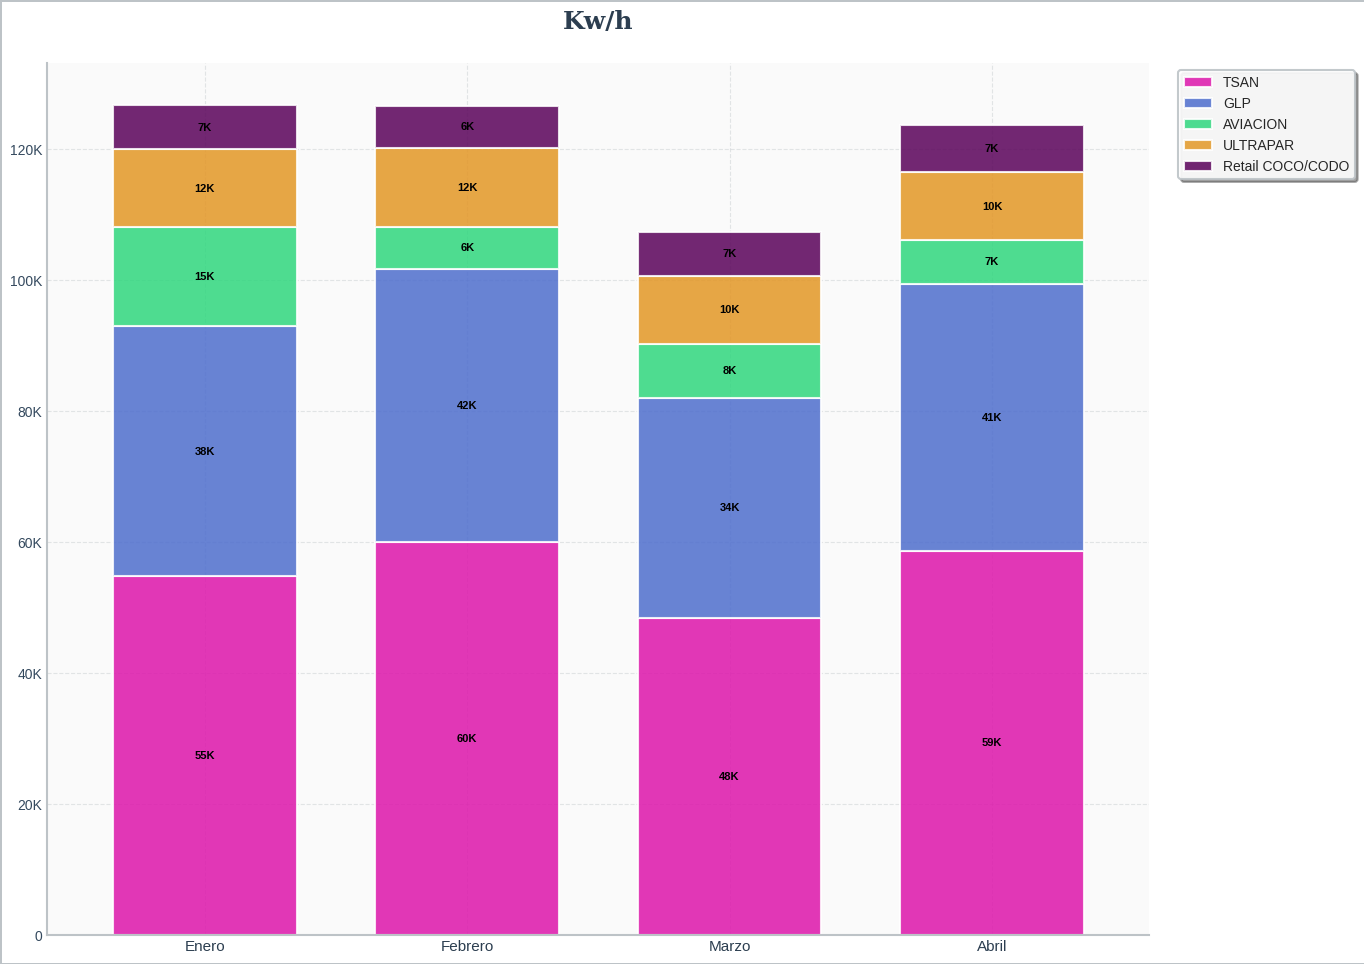

Chart: Residuos SOLIDOS Peligrosos Solidos 
Site color assignments:
  TSAN: #DD15AB
  GLP: #4E6ECD
  AVIACION: #30D77E
  ULTRAPAR: #E39725
Total unique colors used globally: 5
--------------------------------------------------


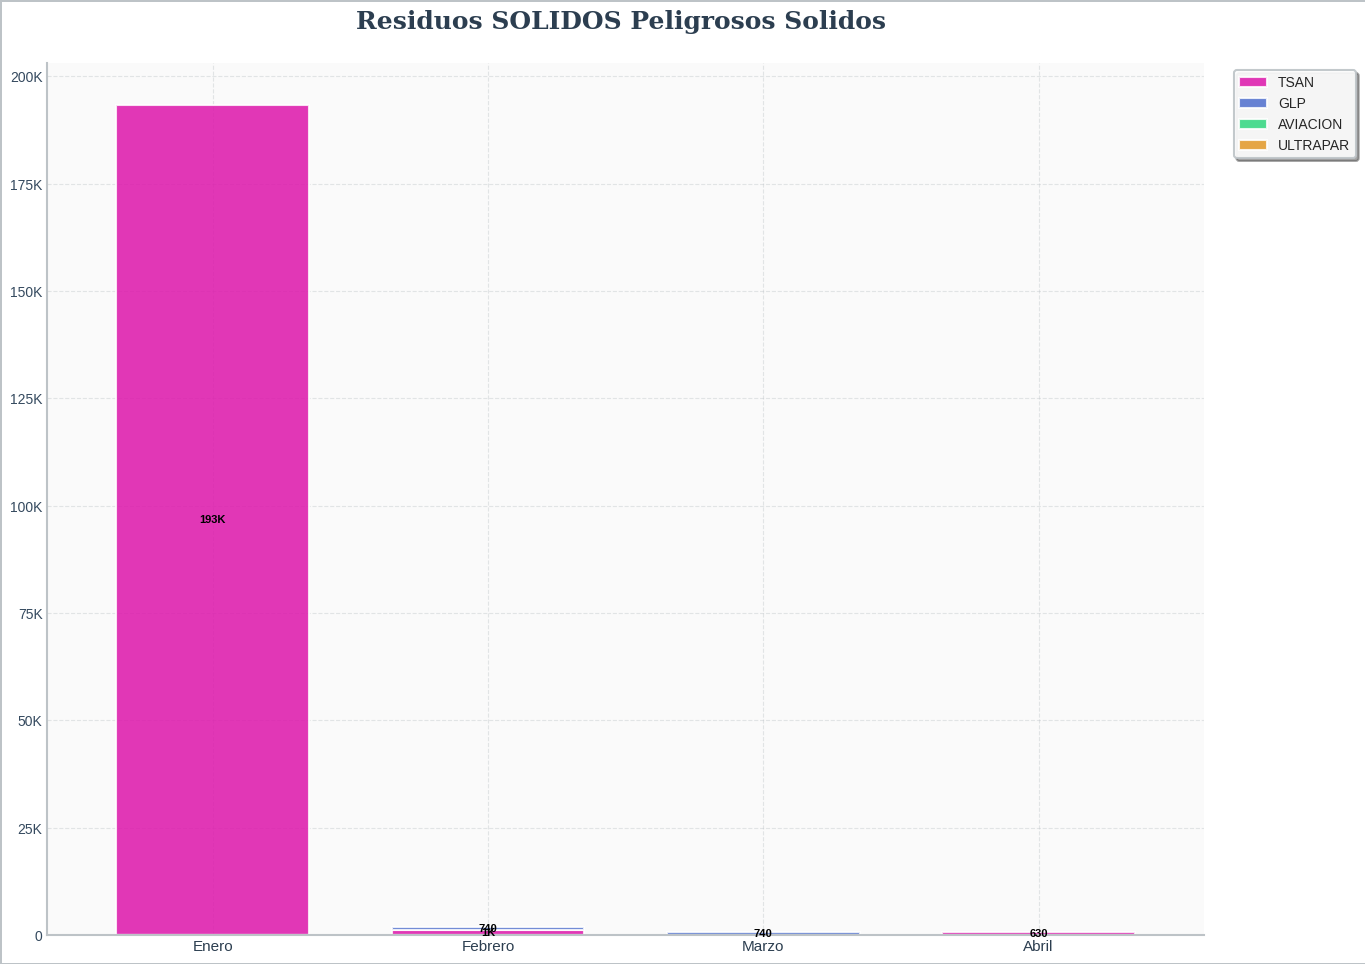

Chart: Residuos LIQUIDOS Peligrosos (Litros)
Site color assignments:
  TSAN: #DD15AB
  GLP: #4E6ECD
  AVIACION: #30D77E
  ULTRAPAR: #E39725
  FLUVIAL: #CF0606
Total unique colors used globally: 6
--------------------------------------------------

Site color assignments:
  TSAN: #DD15AB
  GLP: #4E6ECD
  AVIACION: #30D77E
  ULTRAPAR: #E39725
  FLUVIAL: #CF0606
Total unique colors used globally: 6
--------------------------------------------------


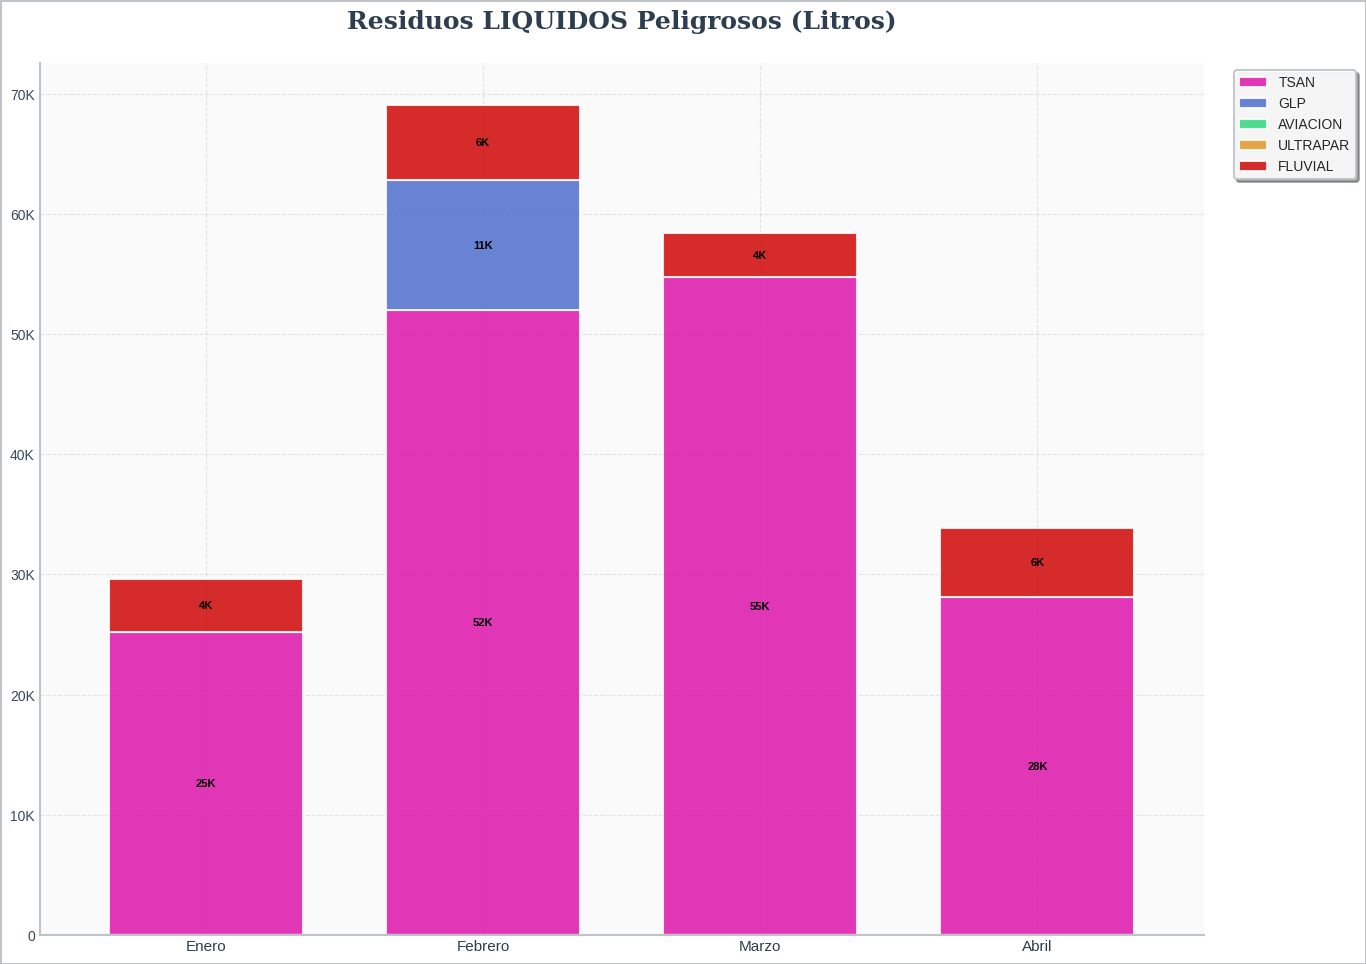

Chart: Residuos Comunes 
Site color assignments:
  TSAN: #DD15AB
  GLP: #4E6ECD
  AVIACION: #30D77E
  ULTRAPAR: #E39725
  FLUVIAL: #CF0606
Total unique colors used globally: 6
--------------------------------------------------


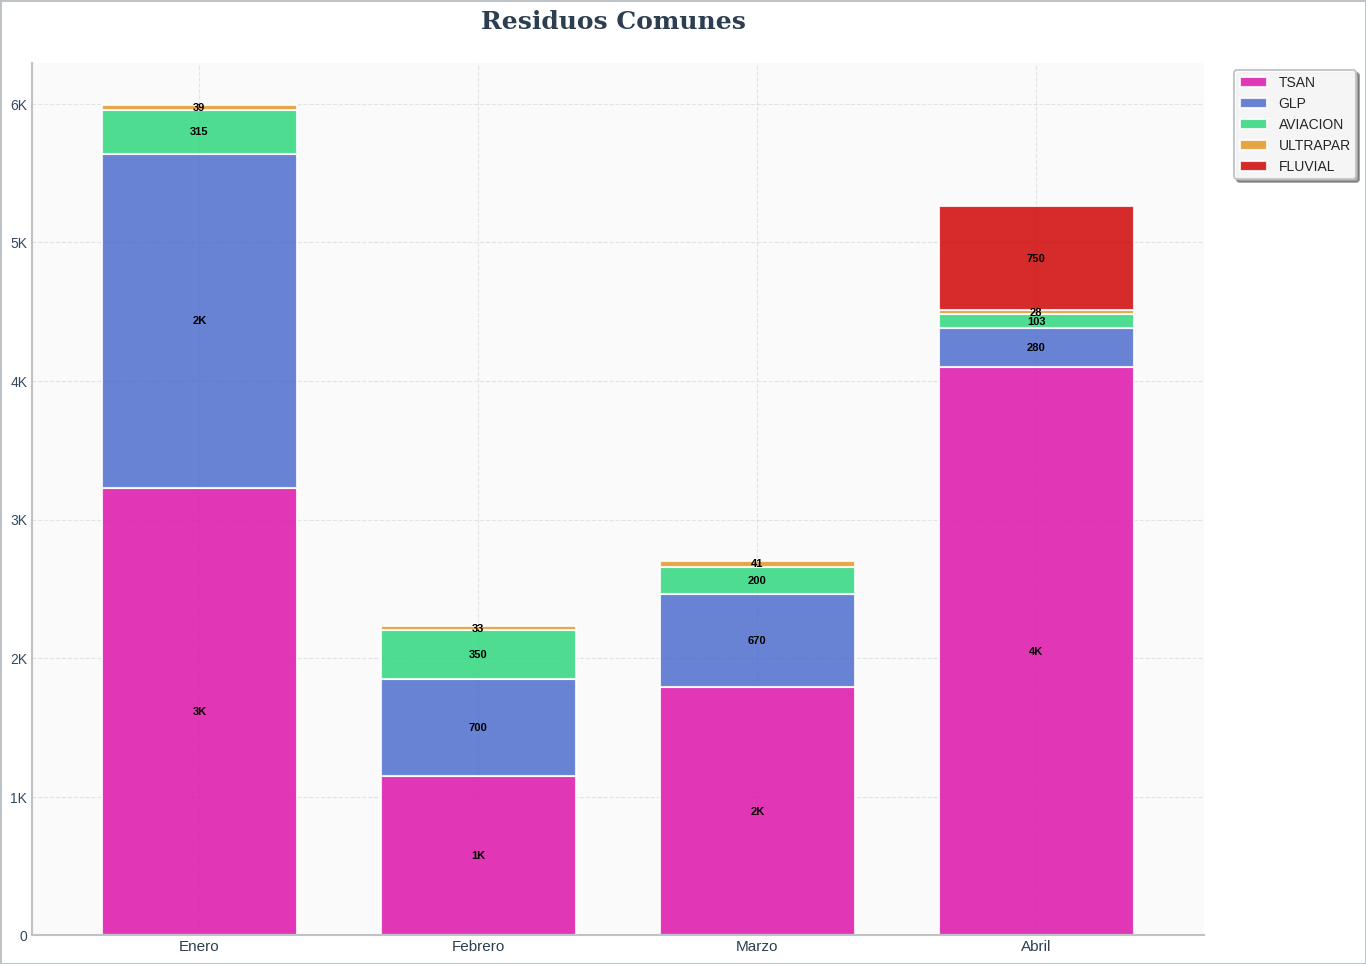

Chart: Consumo de Agua 
Site color assignments:
  TSAN: #DD15AB
  GLP: #4E6ECD
  AVIACION: #30D77E
  ULTRAPAR: #E39725
Total unique colors used globally: 6
--------------------------------------------------


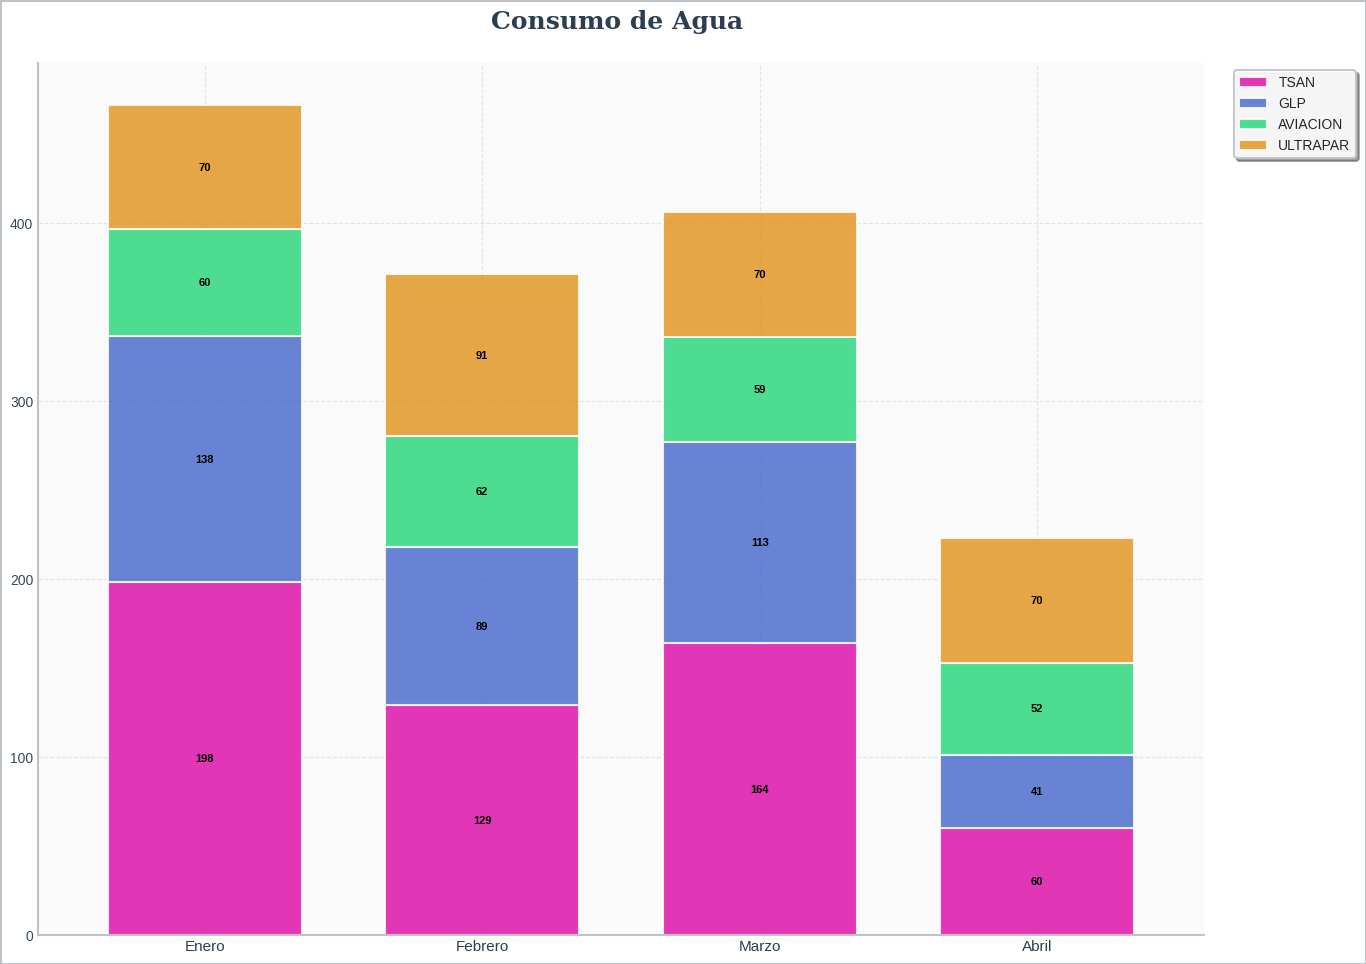

Chart: Km recorridos 
Site color assignments:
  FLOTA DE CAMIONES + FLOTA DE VEHÍCULOS POOL: #1DA6BB
  FLUVIAL : #FFD700
Total unique colors used globally: 8
--------------------------------------------------


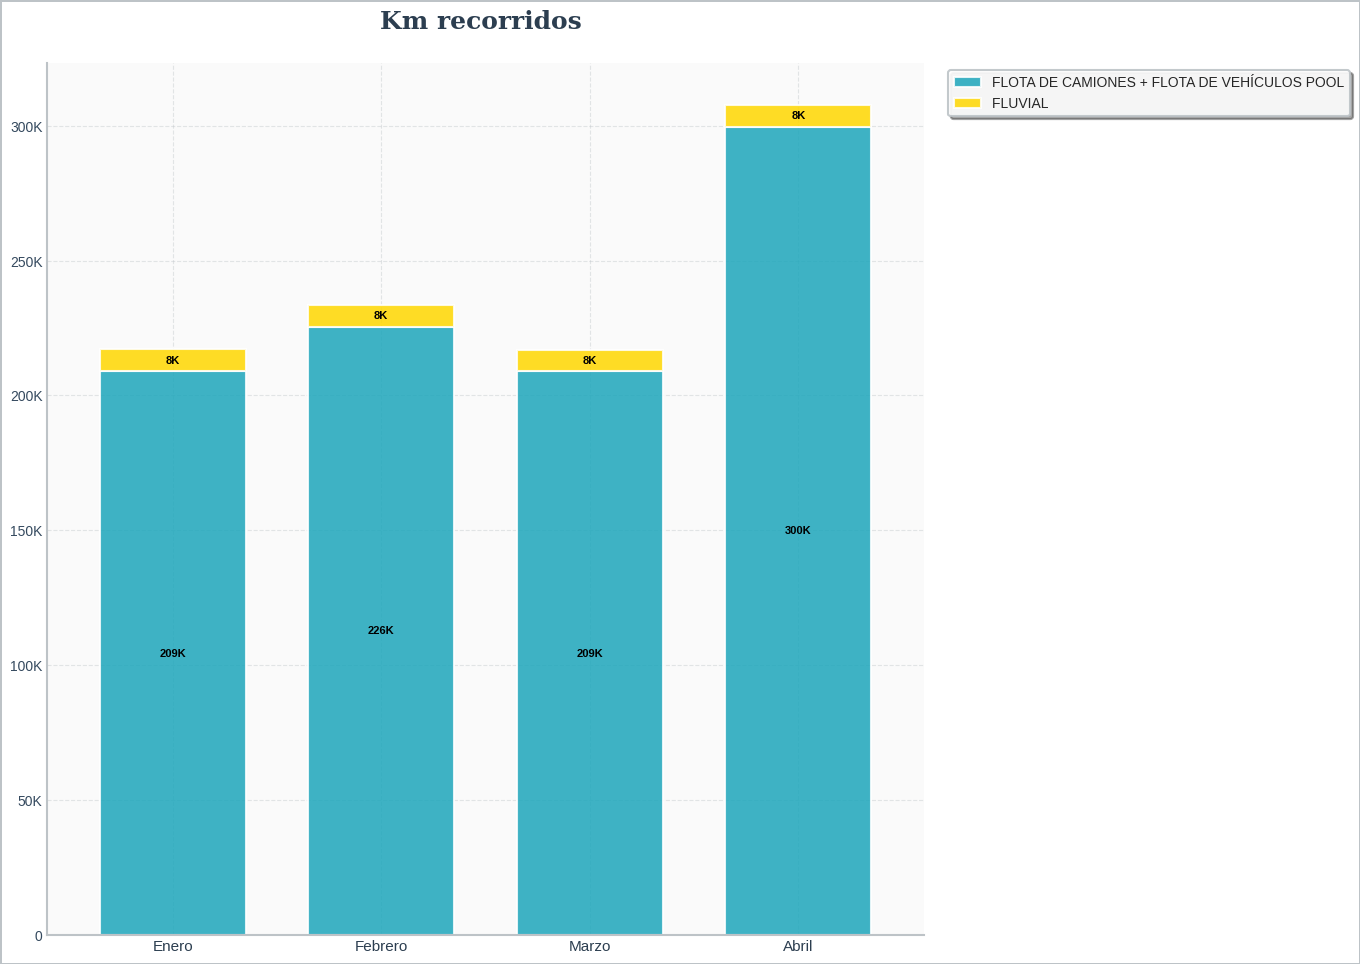

Chart: Consumo de Diesel (Litros)
Site color assignments:
  Flota de vehiculos : #FF6B6B
  REMOLCADORES: #4ECDC4
Total unique colors used globally: 10
--------------------------------------------------


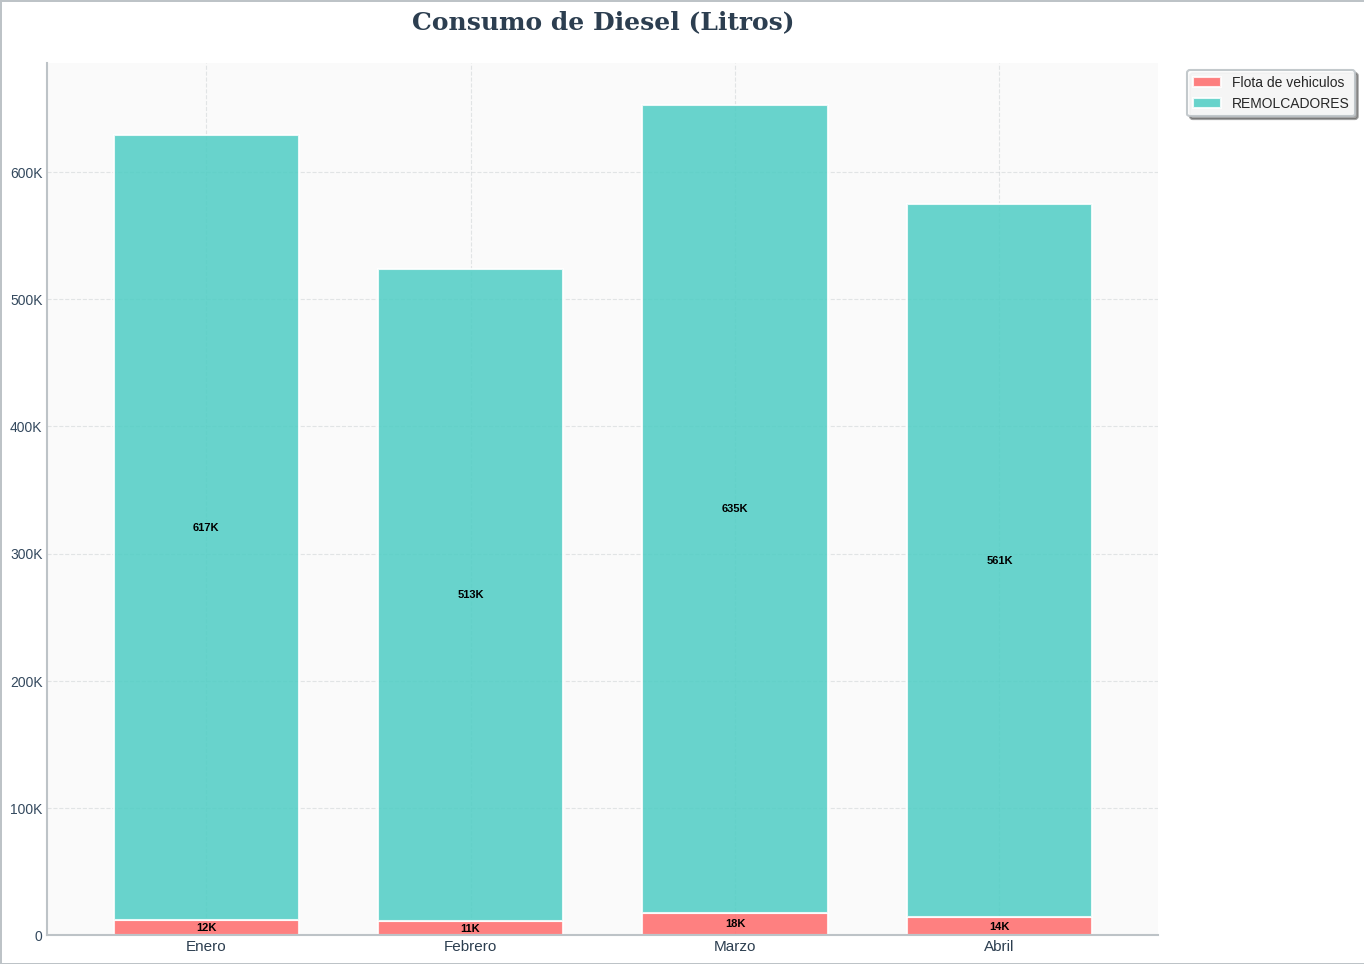

In [26]:
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import hashlib


# Global color tracker to ensure no repeats across all charts
used_colors = set()
site_color_mapping = {}  # Track colors assigned to specific sites


def get_site_color(site_name):
    """Get a consistent unique color for a specific site"""
    global used_colors, site_color_mapping

    # If site already has a color assigned, return it
    if site_name in site_color_mapping:
        return site_color_mapping[site_name]

    # Base high-contrast colors
    base_colors = [
        "#DD15AB",  # Magenta
        "#4E6ECD",  # Blue
        "#30D77E",  # Green
        "#E39725",  # Orange
        "#5A025A",  # Purple
        "#CF0606",  # Red
        "#1DA6BB",  # Teal
        "#FFD700",  # Gold
        "#FF6B6B",  # Coral
        "#4ECDC4",  # Turquoise
        "#45B7D1",  # Sky Blue
        "#96CEB4",  # Mint
        "#FFEAA7",  # Light Yellow
        "#DDA0DD",  # Plum
        "#98D8C8",  # Aqua
        "#F7DC6F",  # Pale Yellow
        "#BB8FCE",  # Lavender
        "#85C1E9",  # Light Blue
    ]

    # First, try to use unused base colors
    for color in base_colors:
        if color not in used_colors:
            used_colors.add(color)
            site_color_mapping[site_name] = color
            return color

    # If all base colors are used, generate a unique color using site name hash
    attempts = 0
    while attempts < 100:  # Safety limit
        # Use site name to generate consistent hue
        hash_value = int(hashlib.md5(site_name.encode()).hexdigest()[:8], 16)
        hue = (
            hash_value + attempts * 47
        ) % 360  # Add attempts to avoid collisions
        saturation = 0.7 + (hash_value % 3) * 0.1  # Vary saturation
        value = 0.8 + (hash_value % 2) * 0.15  # Vary brightness

        # Convert HSV to hex
        rgb = mcolors.hsv_to_rgb([hue / 360, saturation, value])
        hex_color = mcolors.rgb2hex(rgb)

        if hex_color not in used_colors:
            used_colors.add(hex_color)
            site_color_mapping[site_name] = hex_color
            return hex_color

        attempts += 1

    # Fallback: return a default color (should rarely happen)
    fallback_color = "#808080"  # Gray
    site_color_mapping[site_name] = fallback_color
    return fallback_color


# Set modern style and color palette
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

# Create separate charts for each section with enhanced visual appeal
for section_name, df in site_dfs.items():
    # Create a new figure with better proportions
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    fig.patch.set_facecolor("white")

    # Prepare data for stacked bar chart
    month_cols = ["Enero", "Febrero", "Marzo", "Abril"]

    # Create a subset with only the rows that have data
    plot_data = df[df[month_cols].notna().any(axis=1)].copy()

    if len(plot_data) > 0:
        # Set up the data for plotting
        plot_data = plot_data.set_index("Stios")[month_cols]

        # Generate unique colors for each site (not month)
        site_names = plot_data.index.tolist()
        colors = [get_site_color(site) for site in site_names]

        # Create stacked bar chart with enhanced styling
        bars = plot_data.T.plot(
            kind="bar",
            stacked=True,
            ax=ax,
            color=colors,
            alpha=0.85,
            width=0.7,
            edgecolor="white",
            linewidth=1.5,
        )

        # Dynamically resolve section name using first Indicador value
        first_indicador = (
            plot_data.index[0] if len(plot_data) > 0 else "Unknown"
        )
        if "Indicador" in df.columns:
            indicador_values = df["Indicador"].dropna()
            if len(indicador_values) > 0:
                first_indicador = indicador_values.iloc[0]

        # Enhanced title styling
        ax.set_title(
            f"{first_indicador}",
            fontweight="bold",
            fontsize=18,
            pad=25,
            color="#2C3E50",
            fontfamily="serif",
        )

        # Remove axis labels and enhance styling
        ax.set_xlabel("")
        ax.set_ylabel("")

        # Enhanced tick styling
        ax.tick_params(
            axis="x", rotation=0, labelsize=11, colors="#2C3E50", length=0
        )
        ax.tick_params(axis="y", labelsize=10, colors="#34495E")

        # Enhanced legend
        legend = ax.legend(
            bbox_to_anchor=(1.02, 1),
            loc="upper left",
            fontsize=10,
            frameon=True,
            fancybox=True,
            shadow=True,
            framealpha=0.9,
            facecolor="white",
            edgecolor="#BDC3C7",
        )
        legend.get_frame().set_linewidth(1.5)

        # Enhanced grid
        ax.grid(
            True, alpha=0.4, linestyle="--", linewidth=0.8, color="#BDC3C7"
        )
        ax.set_axisbelow(True)

        # Remove top and right spines for cleaner look
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_color("#BDC3C7")
        ax.spines["bottom"].set_color("#BDC3C7")
        ax.spines["left"].set_linewidth(1.5)
        ax.spines["bottom"].set_linewidth(1.5)

        # Format y-axis with enhanced K notation
        def format_thousands(x, pos):
            if x >= 1000000:
                return f"{x / 1000000:.1f}M"
            elif x >= 1000:
                return f"{x / 1000:.0f}K"
            else:
                return f"{x:.0f}"

        ax.yaxis.set_major_formatter(FuncFormatter(format_thousands))

        # Add subtle background gradient effect
        ax.set_facecolor("#FAFAFA")

        # Add value labels on top of bars (optional)
        for container in ax.containers:
            ax.bar_label(
                container,
                labels=[
                    format_thousands(v, None) if v > 0 else ""
                    for v in container.datavalues
                ],
                label_type="center",
                fontsize=8,
                fontweight="bold",
                color="black",
            )

        # Print color assignment for debugging
        print(f"Chart: {first_indicador}")
        print("Site color assignments:")
        for site, color in zip(site_names, colors):
            print(f"  {site}: {color}")
        print(f"Total unique colors used globally: {len(used_colors)}")
        print("-" * 50)

    else:
        # Enhanced no-data message
        ax.text(
            0.5,
            0.5,
            f"{section_name}\n📊 No hay datos disponibles",
            transform=ax.transAxes,
            ha="center",
            va="center",
            fontsize=16,
            fontweight="bold",
            color="#7F8C8D",
            bbox=dict(
                boxstyle="round,pad=0.5",
                facecolor="#ECF0F1",
                edgecolor="#BDC3C7",
                alpha=0.8,
            ),
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

    # Enhanced layout with better spacing
    plt.tight_layout(pad=2.0)

    # Add a subtle border around the entire figure
    fig.patch.set_edgecolor("#BDC3C7")
    fig.patch.set_linewidth(2)

    plt.show()